In [52]:
import os
import numpy as np
from PIL import Image
from sklearn.utils import shuffle
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [43]:
data = []
labels = []

In [44]:
for label in ['yes', 'no']:
    path = os.path.join('brain_tumor_dataset', label)
    for file in os.listdir(path):
        file_path = os.path.join(path, file)
        img = Image.open(file_path).resize((64, 64)).convert('L')  # grayscale resize
        img_np = np.array(img)

        # HOG feature extraction
        features = hog(img_np, 
                       orientations=9, 
                       pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), 
                       block_norm='L2-Hys')

        data.append(features)
        labels.append(1 if label == 'yes' else 0)

In [45]:
data = np.array(data)
labels = np.array(labels)
data, labels = shuffle(data, labels, random_state=42)

In [46]:
print("HOG feature shape:", data.shape)

HOG feature shape: (253, 1764)


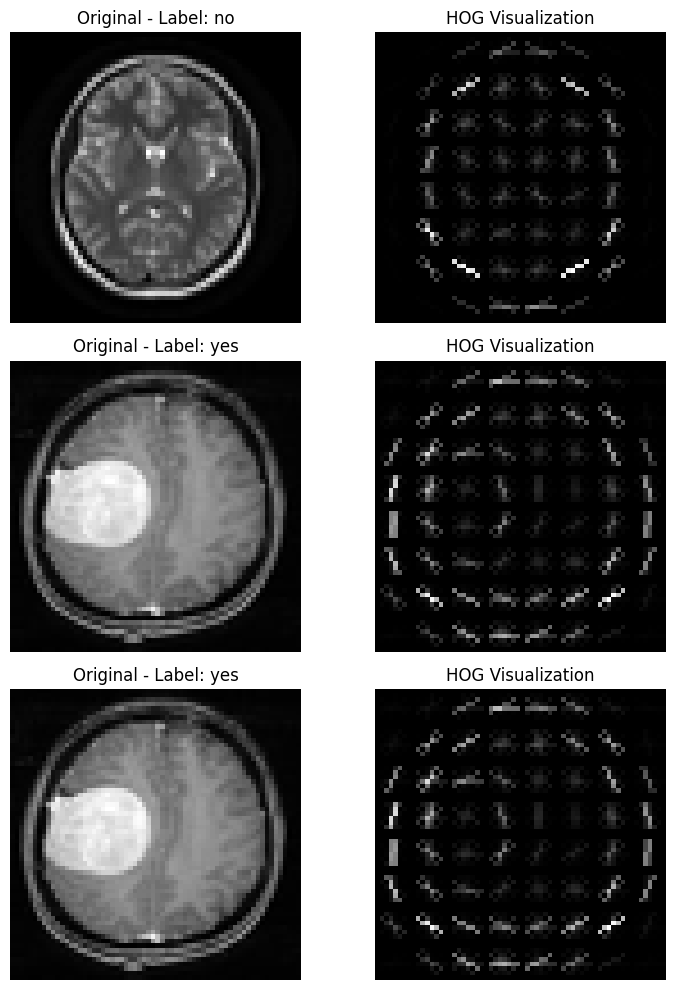

In [51]:
fig, axes = plt.subplots(3, 2, figsize=(8, 10))

for i in range(3):
    label = 'yes' if labels[i] == 1 else 'no'
    image = data[i].reshape(-1)  # Not the raw image

    # Reload original image 
    for file in os.listdir(os.path.join('brain_tumor_dataset', label)):
        img_path = os.path.join('brain_tumor_dataset', label, file)
        img = Image.open(img_path).resize((64, 64)).convert('L')
        img_np = np.array(img)

        # Compute HOG and HOG visualization
        hog_features, hog_image = hog(img_np, 
                                      orientations=9, 
                                      pixels_per_cell=(8, 8),
                                      cells_per_block=(2, 2),
                                      block_norm='L2-Hys',
                                      visualize=True)

        # Plot original and HOG side by side
        axes[i, 0].imshow(img_np, cmap='gray')
        axes[i, 0].set_title(f"Original - Label: {label}")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(hog_image, cmap='gray')
        axes[i, 1].set_title("HOG Visualization")
        axes[i, 1].axis('off')
        break  

plt.tight_layout()
plt.show()

In [54]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=42)

In [60]:
model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# Predict probabilities instead of labels
y_proba = model.predict_proba(X_test)[:, 1]  # probability for class 1 (tumor)

#  Choose a threshold
threshold = 0.64  
y_pred = (y_proba > threshold).astype(int)

#  Evaluate
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=["No Tumor", "Tumor"]))

[[18  2]
 [ 2 29]]
              precision    recall  f1-score   support

    No Tumor       0.90      0.90      0.90        20
       Tumor       0.94      0.94      0.94        31

    accuracy                           0.92        51
   macro avg       0.92      0.92      0.92        51
weighted avg       0.92      0.92      0.92        51



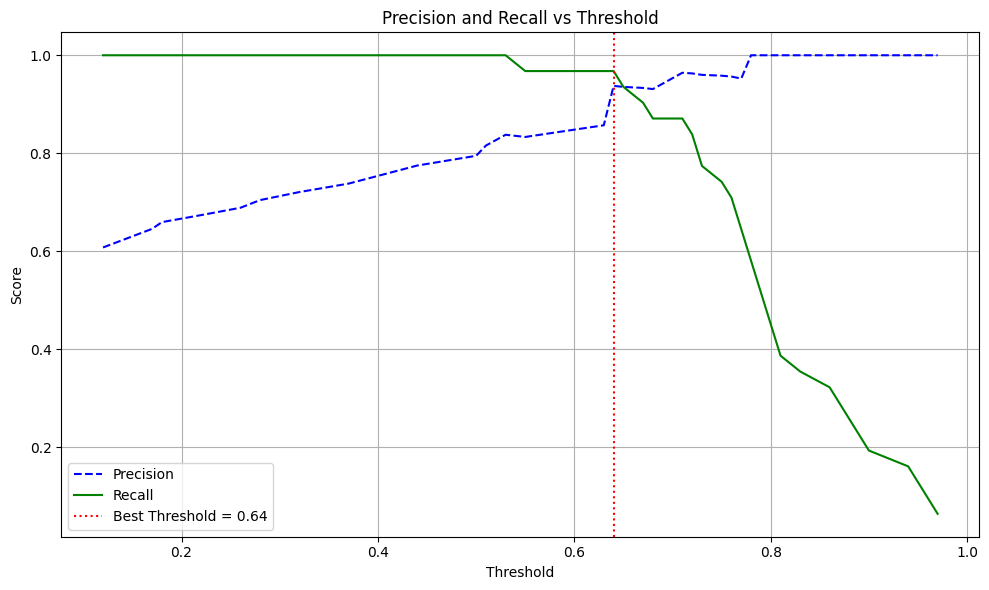

In [61]:
# Compute precision, recall, thresholds
prec, rec, thresholds = precision_recall_curve(y_test, y_proba)

# Plot precision and recall vs threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, prec[:-1], "b--", label="Precision")
plt.plot(thresholds, rec[:-1], "g-", label="Recall")

# Annotate best point 
f1 = 2 * (prec[:-1] * rec[:-1]) / (prec[:-1] + rec[:-1])
best_idx = np.argmax(f1)
best_thresh = thresholds[best_idx]
plt.axvline(best_thresh, color='red', linestyle=':', label=f'Best Threshold = {best_thresh:.2f}')

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision and Recall vs Threshold")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()